# My Scaling Law Plots
---

Parameters to vary:
1. Sequence length (time steps recorded)
2. Number of worms (number of individuals)
3. Number of neurons recorded (labeling neurons)
4. Do we need labeled neurons or we can atribute randomly?

Other questions could be:
1. How the optimization time evolves with the amount of data?
2. And with the amount of used neurons?

In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

from data._main import *

from models._main import *

from train._main import *

config_train = OmegaConf.load("../../../conf/train.yaml")
print("config:", OmegaConf.to_yaml(config_train), end="\n\n")

model = get_model(OmegaConf.load("../../../conf/model.yaml"))

dataset = get_dataset(OmegaConf.load("../../../conf/dataset.yaml"))

model, log_dir, config_train = train_model(
    config_train,
    model,
    dataset,
    shuffle_worms=False,
    log_dir=os.path.join("logs", "{}".format(datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))),
)

In [2]:
from tests.leandro.mini_connectome import *
from tests.leandro.plots import *
from omegaconf import OmegaConf
from data._main import *
from tests.leandro.my_dataloaders import *

/home/lrvnc/miniconda3/envs/worm-graph/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
miniconnectome = MiniConnectome(direction='TD', group_by='four')
connected_to_M3L = miniconnectome.get_connected_neurons('M3L', index=False)
miniconnectome.minigraph.add_nodes('M3L', connected_to_M3L)
miniconnectome.minigraph.add_nodes(connected_to_M3L[0], miniconnectome.get_connected_neurons(connected_to_M3L[0], index=False)[2:3])

miniconnectome.minigraph.display(save=False, filename='M3L.png')

# Create the dataloader
---

In [6]:
# Load the dict dataset
config = OmegaConf.load("../../../conf/dataset.yaml")
dict_dataset = get_dataset(config)

Chosen dataset(s): ['Flavell2023']
Num. worms: 50



In [25]:
cohort_trainloaders, cohort_testloaders = get_dataloaders(
    dict_dataset = dict_dataset,
    number_cohorts = 1,
    use_residual = False,
    k_splits = 2, # Number of chunks to split the data: 1 chunk = 1 train/test split. Order: train, test, train, test, ...
    seq_len = 100, # Number of time steps to extract from each chunk (time steps of each example)
    num_samples = 100, # Total number of sample pairs (input,target) to extract from each worm
    reverse = False, # If True, the time series is reversed
    tau = 10, # Number of time steps to shift the target (number of time steps we want to predict ahead)
    batch_size = 32,
    shuffle_samples = False,
    desired_neurons_to_train = None,
    use_mask = False, # If use mask = True, the calcium data is (seq_len, 302). If false, the calcium data is (seq_len, desired_neurons_to_train)
    shuffle_worms = True,
)

Cohort: 50 worms
Train dataset: 5024 samples
Test dataset: 5024 samples


In [19]:
x_batch, y_batch, metadata, mask = next(iter(cohort_trainloaders[0]))

In [81]:
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt

class MaskedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MaskedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, mask):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Initial states
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c = torch.zeros(batch_size, self.hidden_size).to(x.device)

        # Create lists to save outputs
        hidden_outputs = []
        cell_outputs = []

        # Step through the sequence
        for t in range(seq_len):
            # Use mask to set irrelevant features to zero
            x_t = x[:, t, :] * mask

            # Forward pass through LSTM cell
            h, c = self.lstm_cell(x_t, (h, c))

            # Save outputs
            hidden_outputs.append(h)
            cell_outputs.append(c)

        # Stack hidden and cell outputs into (batch_size, seq_len, hidden_size) tensors
        hidden_outputs = torch.stack(hidden_outputs, dim=1)
        cell_outputs = torch.stack(cell_outputs, dim=1)

        prediction = nn.functional.sigmoid(self.fc(cell_outputs))

        return prediction

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = nn.functional.sigmoid(self.fc(out))
        return out

# input_dim corresponds to the number of features (302 in our case)
# hidden_dim can be chosen based on the complexity of our task
# output_dim is again 302 as we are predicting a single value at each timestep
# n_layers is the number of LSTM layers in the network

model_with_mask = MaskedLSTM(input_size=302, hidden_size=64, output_size=302, num_layers=3)
model_no_mask = LSTMModel(input_dim=1, hidden_dim=64, output_dim=1, n_layers=3)

In [82]:
cohort_trainloaders, cohort_testloaders = get_dataloaders(
    dict_dataset = dict_dataset,
    number_cohorts = 1,
    use_residual = False,
    k_splits = 2, # Number of chunks to split the data: 1 chunk = 1 train/test split. Order: train, test, train, test, ...
    seq_len = 100, # Number of time steps to extract from each chunk (time steps of each example)
    num_samples = 100, # Total number of sample pairs (input,target) to extract from each worm
    reverse = False, # If True, the time series is reversed
    tau = 10, # Number of time steps to shift the target (number of time steps we want to predict ahead)
    batch_size = 32,
    shuffle_samples = False,
    desired_neurons_to_train = None,
    use_mask = True, # If use mask = True, the calcium data is (seq_len, 302). If false, the calcium data is (seq_len, desired_neurons_to_train)
    shuffle_worms = True,
)

x_batch, y_batch, metadata, mask_batch = next(iter(cohort_trainloaders[0]))
model_with_mask(x_batch, mask_batch).shape, y_batch.shape

Cohort: 50 worms
Train dataset: 5024 samples
Test dataset: 5024 samples


(torch.Size([32, 100, 302]), torch.Size([32, 100, 302]))

In [83]:
cohort_trainloaders, cohort_testloaders = get_dataloaders(
    dict_dataset = dict_dataset,
    number_cohorts = 1,
    use_residual = False,
    k_splits = 2, # Number of chunks to split the data: 1 chunk = 1 train/test split. Order: train, test, train, test, ...
    seq_len = 100, # Number of time steps to extract from each chunk (time steps of each example)
    num_samples = 100, # Total number of sample pairs (input,target) to extract from each worm
    reverse = False, # If True, the time series is reversed
    tau = 10, # Number of time steps to shift the target (number of time steps we want to predict ahead)
    batch_size = 32,
    shuffle_samples = False,
    desired_neurons_to_train = ['M3L'],
    use_mask = False, # If use mask = True, the calcium data is (seq_len, 302). If false, the calcium data is (seq_len, desired_neurons_to_train)
    shuffle_worms = True,
)

x_batch, y_batch, metadata, mask_batch = next(iter(cohort_trainloaders[0]))
model_no_mask(x_batch).shape, y_batch.shape

Cohort: 50 worms
Train dataset: 5024 samples
Test dataset: 5024 samples


(torch.Size([32, 100, 1]), torch.Size([32, 100, 1]))

In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

number_cohorts = 50

# Create trainloaders
cohort_trainloaders, cohort_testloaders = get_dataloaders(
    dict_dataset = dict_dataset,
    number_cohorts = number_cohorts,
    use_residual = False,
    k_splits = 2, # Number of chunks to split the data: 1 chunk = 1 train/test split. Order: train, test, train, test, ...
    seq_len = 100, # Number of time steps to extract from each chunk (time steps of each example)
    num_samples = 100, # Total number of sample pairs (input,target) to extract from each worm
    reverse = False, # If True, the time series is reversed
    tau = 10, # Number of time steps to shift the target (number of time steps we want to predict ahead)
    batch_size = 32,
    shuffle_samples = False,
    desired_neurons_to_train = None,
    use_mask = True, # If use mask = True, the calcium data is (seq_len, 302). If false, the calcium data is (seq_len, desired_neurons_to_train)
    shuffle_worms = True,
)

# Model to device
model = model_with_mask.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.0001)

# Training loop
train_loss = []
test_loss = []

for epoch, (trainloader, testloader) in enumerate(zip(cohort_trainloaders, cohort_testloaders)):
    model.train()
    epoch_losses = []
    for i, (x_batch, y_batch, metadata, mask_batch) in enumerate(trainloader):

        # Move data to GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(x_batch, mask_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    train_loss.append(np.mean(epoch_losses))

    # After each epoch, calculate the test loss
    model.eval()
    epoch_losses = []
    with torch.no_grad():
        for i, (test_x, test_y, metadata, test_mask) in enumerate(testloader):
            test_x = test_x.to(device)
            test_y = test_y.to(device)
            test_mask = test_mask.to(device)
            predictions = model(test_x, test_mask)
            loss = criterion(predictions, test_y)
            epoch_losses.append(loss.item())
        test_loss.append(np.mean(epoch_losses))

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{number_cohorts}, Train Loss: {round(train_loss[-1], 5)}, Test Loss: {round(test_loss[-1], 5)}')

Using device: cpu
Cohort: 50 worms
Train dataset: 5024 samples
Test dataset: 5024 samples
Epoch 0/50, Train Loss: 0.74266, Test Loss: 0.61671
Epoch 10/50, Train Loss: 0.41927, Test Loss: 0.43844


KeyboardInterrupt: 

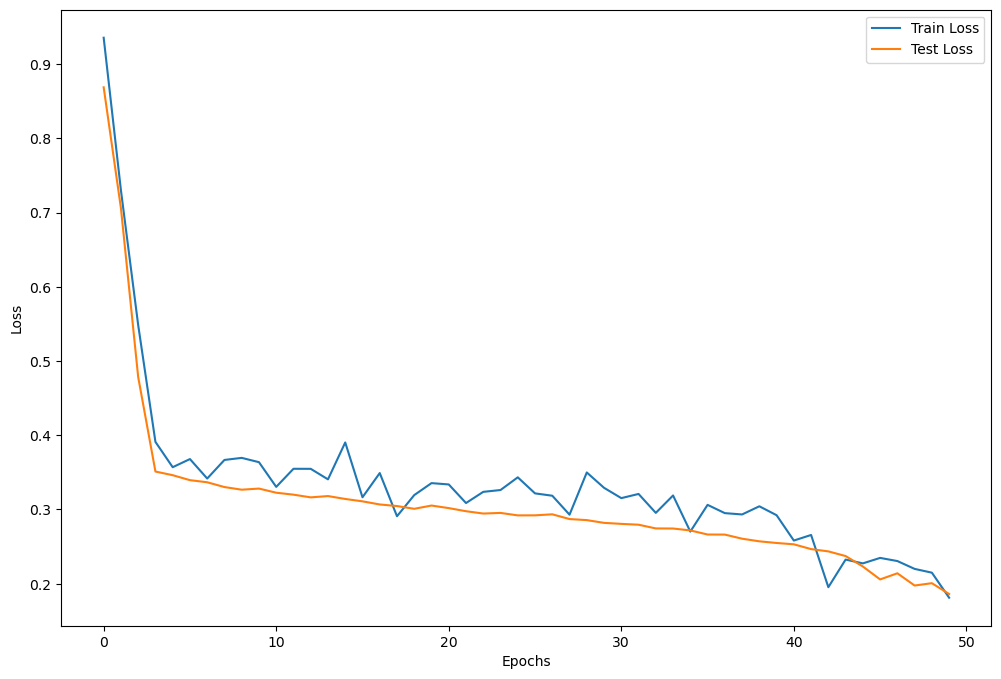

In [12]:
# Plot the train and test loss
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

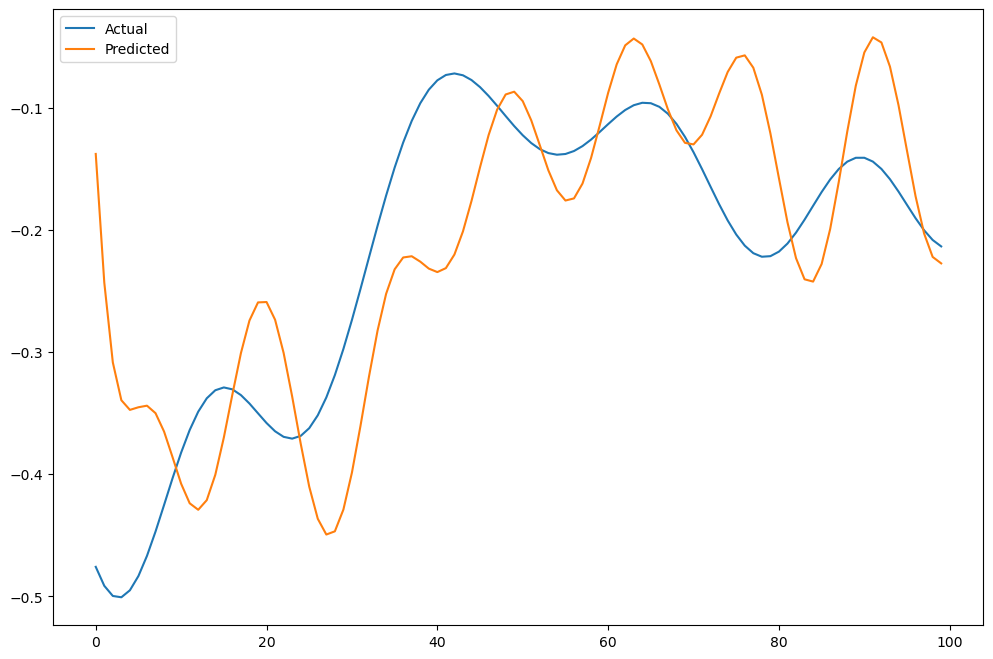

In [14]:
# plot the first 10 predictions vs actual values
model.eval()
with torch.no_grad():
    for i, (test_x, test_y, metadata, test_mask) in enumerate(testloader):
        test_x = test_x.to(device)
        test_y = test_y.to(device)
        test_mask = test_mask.to(device)
        predictions = model(test_x, test_mask, use_mask)
        break

plt.figure(figsize=(12, 8))
plt.plot(test_y[1, :, 0].cpu(), label='Actual')
plt.plot(predictions[1, :, 0].cpu(), label='Predicted')
plt.legend()
